Importando libs

In [87]:
from sklearn.preprocessing import LabelBinarizer
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

Carregando Dataframes

In [88]:
df_train = pd.read_csv('./data/conjunto_de_treinamento.csv')
df_test = pd.read_csv('./data/conjunto_de_teste.csv')

Removendo colunas desnecessárias

In [89]:
to_be_removed = ['Id', 'diferenciais']

df_test_ids = df_test.iloc[:,0]

df_train = df_train.drop(to_be_removed, axis=1)
df_test = df_test.drop(to_be_removed, axis=1)

Separando variáveis categóricas não binárias e aplicando one hot encoding

In [90]:
binarias = ['tipo_vendedor']
categoricas_nao_binarias = ['tipo', 'bairro']

df_train = pd.get_dummies(df_train,columns=categoricas_nao_binarias)
df_test = pd.get_dummies(df_test,columns=categoricas_nao_binarias)

binarizador = LabelBinarizer()

for b in binarias:
    df_train[b] = binarizador.fit_transform(df_train[b])
    df_test[b] = binarizador.fit_transform(df_test[b])


Aplicando MinMaxScaling em variáveis númericas ordinais

In [91]:
to_scale = ['quartos', 'suites', 'vagas', 'area_util', 'area_extra']
scaler = MinMaxScaler()

for dataframe in [df_train, df_test]:
    dataframe[to_scale] = scaler.fit_transform(dataframe[to_scale])

Matriz de Correlação

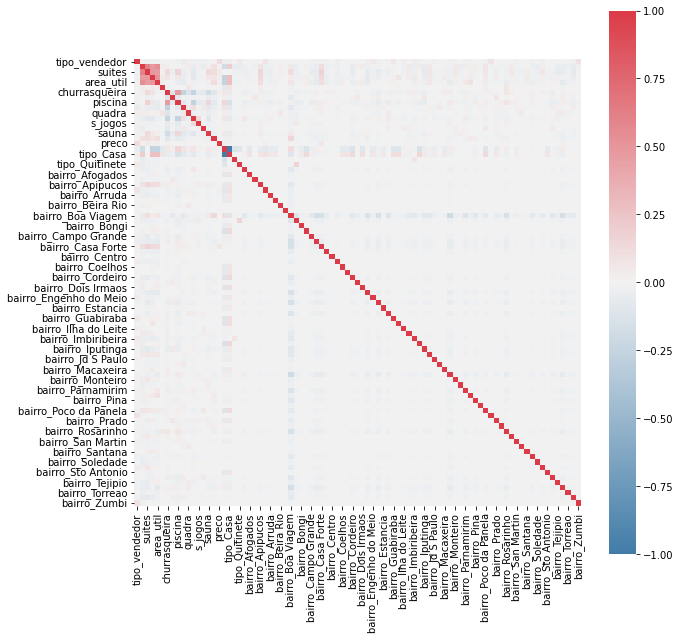

In [92]:
corrMatrix = df_train.corr()
_, _ = plt.subplots(figsize=(10,10)), sn.heatmap(corrMatrix, cmap=sn.diverging_palette(240,10,n=256), vmin=-1, vmax=1, square=True)
plt.show()

Calculando RMSPE

In [93]:
def rmspe(y, y_answer):
    value = np.sqrt(np.mean(np.square(((y - y_answer) / y)), axis=0))
    return value

Preparando datasets após transformações que manipulam colunas

In [94]:
missing_cols_test = list(set(df_train.columns) - set(df_test.columns))
missing_cols_train = list(set(df_test.columns) - set(df_train.columns))

# As colunas que são adicionadas aqui são originárias dos one-hot encoding realizados, por isso, colocamos para 0
for col in missing_cols_test:
    if col == 'preco': continue

    df_test[col] = 0

for col in missing_cols_train:
    df_train[col] = 0

Predição de Teste dos hiperparâmetros

In [95]:
x_df = df_train.loc[:,df_train.columns != 'preco']
y_df = df_train.loc[:,'preco']
x = x_df.to_numpy()
y = y_df.to_numpy()
regressor = HistGradientBoostingRegressor(l2_regularization=12, max_iter=45, loss='absolute_error', max_depth=16)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.2, random_state=0)
pred = regressor.fit(x_treino,y_treino).predict(x_teste)

print(rmspe(y_teste, pred))

0.25278018246070927


Treinando o modelo final

In [96]:
df_test = pd.DataFrame(df_test)
model = regressor.fit(x,y)
prediction = model.predict(df_test)
df_args = { 'Id': df_test_ids.index, 'preco': prediction }
prediction = pd.DataFrame(df_args)
prediction.to_csv('./submission.csv', index=False)

/home/guima/.local/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(
